# 🏃 Análise Completa de Recuperação
## Análise científica da sua recuperação e readiness para treinar

**📊 Métricas disponíveis:**  
• **🩺 RHR**: 1,029 registros de frequência cardíaca de repouso (3+ anos)  
• **🔋 Body Battery**: 1,026 dias de dados de energia e fadiga  
• **🏃 Training Load**: 823 atividades com TSS (Training Stress Score)  
• **🫁 Freq. Respiratória**: 1,028 dias de dados  
• **😴 Sono + 😌 Estresse**: Correlações completas disponíveis  

**🎯 Objetivo:** Entender padrões de recuperação, otimizar treinamento e prevenir overtraining


In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

# Conectar aos bancos de dados do GarminDB
garmin_db_path = os.path.expanduser('~/HealthData/DBs/garmin.db')
activities_db_path = os.path.expanduser('~/HealthData/DBs/garmin_activities.db')

conn_garmin = sqlite3.connect(garmin_db_path)
conn_activities = sqlite3.connect(activities_db_path)

print('✅ Conectado aos bancos GarminDB')
print('🏃 Preparando análise de recuperação...')
print('📊 Carregando métricas de RHR, Body Battery, TSS e correlações...')


✅ Conectado aos bancos GarminDB
🏃 Preparando análise de recuperação...
📊 Carregando métricas de RHR, Body Battery, TSS e correlações...


In [2]:
# Carregar todos os dados de recuperação
print("🏃 CARREGANDO DADOS DE RECUPERAÇÃO")
print("=" * 50)

# 1. Dados de RHR (Frequência Cardíaca de Repouso)
rhr_query = """
SELECT 
    day,
    resting_heart_rate
FROM resting_hr 
WHERE day >= date('now', '-365 days')
  AND resting_heart_rate IS NOT NULL
ORDER BY day DESC;
"""

df_rhr = pd.read_sql_query(rhr_query, conn_garmin)
df_rhr['day'] = pd.to_datetime(df_rhr['day'])

print(f"🩺 RHR: {len(df_rhr)} registros carregados")
print(f"   📊 RHR médio: {df_rhr['resting_heart_rate'].mean():.1f} bpm")
print(f"   📊 Faixa: {df_rhr['resting_heart_rate'].min():.0f} - {df_rhr['resting_heart_rate'].max():.0f} bpm")

# 2. Dados de Body Battery e métricas diárias
daily_summary_query = """
SELECT 
    day,
    rhr,
    stress_avg,
    bb_charged,
    bb_max,
    bb_min,
    rr_waking_avg,
    rr_max,
    rr_min,
    spo2_avg,
    calories_total,
    steps,
    vigorous_activity_time,
    moderate_activity_time
FROM daily_summary 
WHERE day >= date('now', '-365 days')
ORDER BY day DESC;
"""

df_daily = pd.read_sql_query(daily_summary_query, conn_garmin)
df_daily['day'] = pd.to_datetime(df_daily['day'])

# Converter tempos de atividade para minutos
def time_to_minutes(time_str):
    if pd.isna(time_str) or time_str == '00:00:00':
        return 0
    try:
        hours = int(time_str[:2])
        minutes = int(time_str[3:5])
        return hours * 60 + minutes
    except:
        return 0

df_daily['vigorous_minutes'] = df_daily['vigorous_activity_time'].apply(time_to_minutes)
df_daily['moderate_minutes'] = df_daily['moderate_activity_time'].apply(time_to_minutes)
df_daily['total_activity_minutes'] = df_daily['vigorous_minutes'] + df_daily['moderate_minutes']

print(f"🔋 Body Battery: {len(df_daily[df_daily['bb_charged'].notna()])} dias com dados")
print(f"   📊 Recarga média: {df_daily['bb_charged'].mean():.1f}%")
print(f"   📊 Energia máxima média: {df_daily['bb_max'].mean():.1f}%")

# 3. Dados de Training Load (TSS)
tss_query = """
SELECT 
    substr(start_time, 1, 10) as date,
    activity_id,
    sport,
    type,
    training_load,
    training_effect,
    anaerobic_training_effect,
    calories,
    avg_hr,
    max_hr,
    distance,
    CAST(strftime('%s', stop_time) - strftime('%s', start_time) AS REAL) / 3600.0 as duration_hours
FROM activities 
WHERE start_time >= date('now', '-365 days')
  AND training_load IS NOT NULL
ORDER BY start_time DESC;
"""

df_tss = pd.read_sql_query(tss_query, conn_activities)
df_tss['date'] = pd.to_datetime(df_tss['date'])

print(f"🏃 Training Load: {len(df_tss)} atividades carregadas")
print(f"   📊 TSS médio: {df_tss['training_load'].mean():.1f}")
print(f"   📊 Modalidades: {df_tss['sport'].nunique()} diferentes")

# Dados de sono (para correlações)
sleep_query = """
SELECT 
    day,
    total_sleep,
    score as sleep_score,
    deep_sleep,
    rem_sleep
FROM sleep 
WHERE day >= date('now', '-365 days')
ORDER BY day DESC;
"""

df_sleep = pd.read_sql_query(sleep_query, conn_garmin)
df_sleep['day'] = pd.to_datetime(df_sleep['day'])

print(f"😴 Sono: {len(df_sleep)} noites para correlação")

# Combinar todas as métricas em um DataFrame master
recovery_data = df_rhr.copy()
recovery_data = pd.merge(recovery_data, df_daily, on='day', how='outer')
recovery_data = pd.merge(recovery_data, df_sleep, on='day', how='outer')

# Agregar TSS por dia
daily_tss = df_tss.groupby('date').agg({
    'training_load': ['sum', 'mean', 'count'],
    'training_effect': 'mean', 
    'anaerobic_training_effect': 'mean',
    'duration_hours': 'sum'
}).round(1)

daily_tss.columns = ['tss_total', 'tss_mean', 'activities_count', 'aerobic_effect', 'anaerobic_effect', 'training_hours']
daily_tss = daily_tss.reset_index()
daily_tss['date'] = pd.to_datetime(daily_tss['date'])

recovery_data = pd.merge(recovery_data, daily_tss, left_on='day', right_on='date', how='outer')

print(f"\n📊 DADOS COMBINADOS:")
print(f"   📅 Período: {recovery_data['day'].min().date()} até {recovery_data['day'].max().date()}")
print(f"   📊 Dias com dados: {len(recovery_data)}")
print(f"   📊 Dias com RHR: {recovery_data['resting_heart_rate'].count()}")
print(f"   📊 Dias com Body Battery: {recovery_data['bb_charged'].count()}")
print(f"   📊 Dias com atividades: {recovery_data['activities_count'].count()}")

print(f"\n📈 Dados carregados! Execute as próximas células para análises detalhadas...")


🏃 CARREGANDO DADOS DE RECUPERAÇÃO
🩺 RHR: 364 registros carregados
   📊 RHR médio: 53.0 bpm
   📊 Faixa: 43 - 61 bpm
🔋 Body Battery: 364 dias com dados
   📊 Recarga média: 54.7%
   📊 Energia máxima média: 78.8%
🏃 Training Load: 273 atividades carregadas
   📊 TSS médio: 126.8
   📊 Modalidades: 6 diferentes
😴 Sono: 365 noites para correlação

📊 DADOS COMBINADOS:
   📅 Período: 2024-09-09 até 2025-09-08
   📊 Dias com dados: 366
   📊 Dias com RHR: 364
   📊 Dias com Body Battery: 364
   📊 Dias com atividades: 249

📈 Dados carregados! Execute as próximas células para análises detalhadas...


/var/folders/pm/gfxqw0wd6dz35t8_f0blfkmw0000gn/T/ipykernel_90373/2200304821.py:88: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) Arial.
  plt.tight_layout()
/Users/pmdusso/code/GarminDB/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127939 (\N{RUNNER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


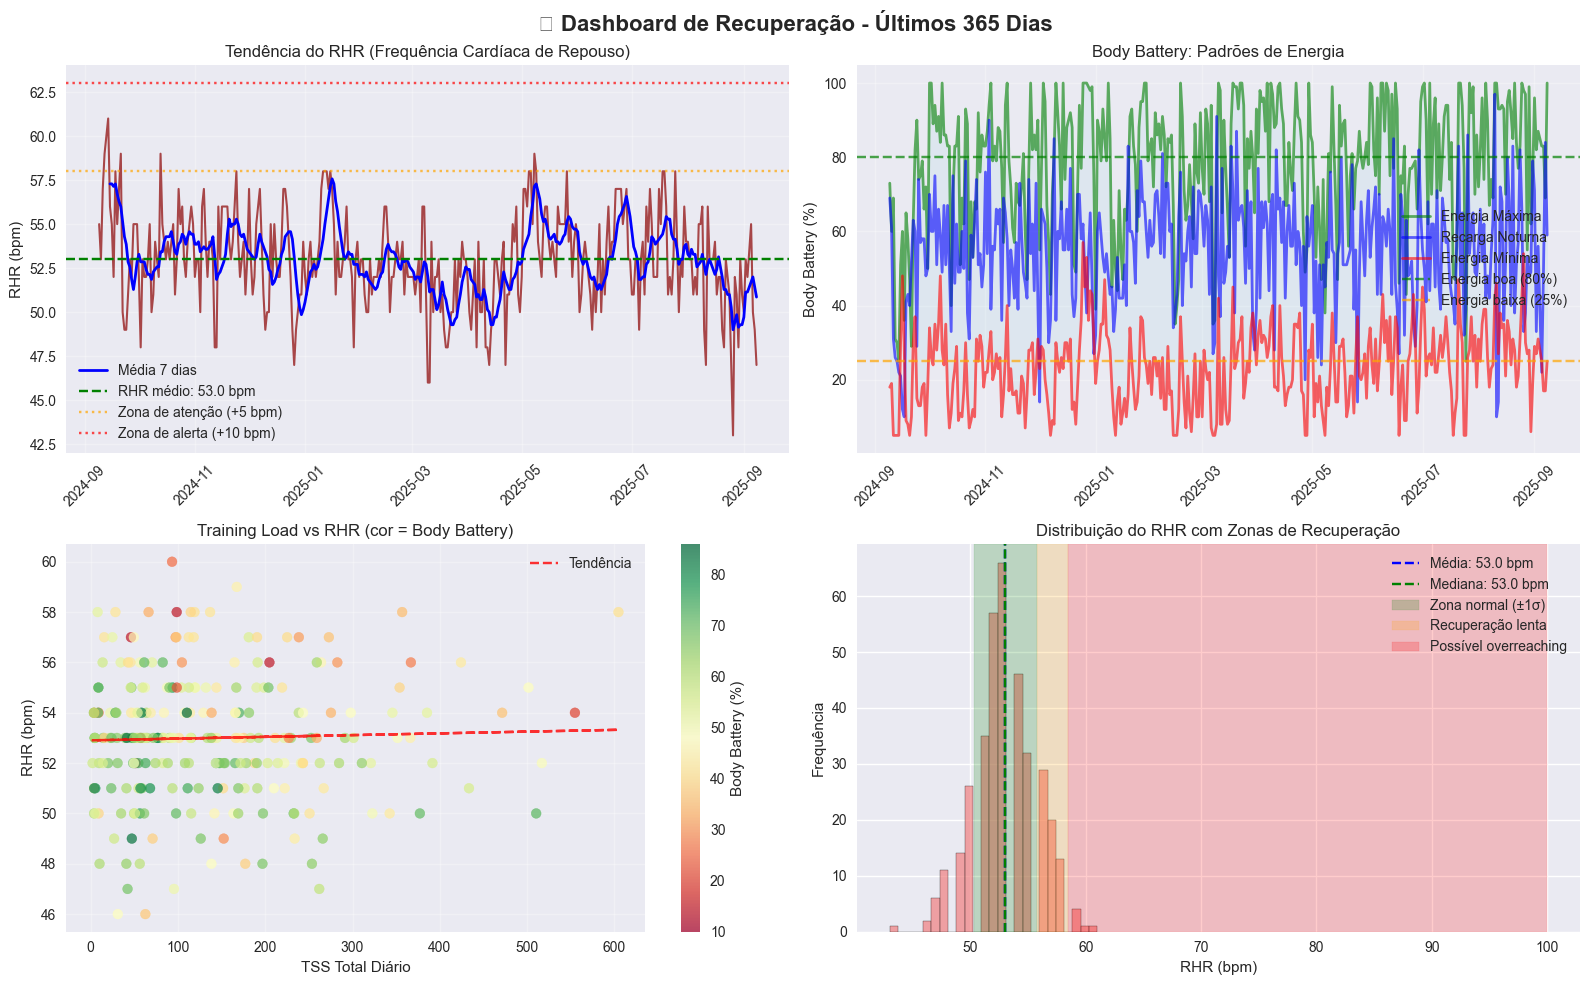

✨ Dashboard principal de recuperação criado!


In [3]:
# Dashboard Principal de Recuperação
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('🏃 Dashboard de Recuperação - Últimos 365 Dias', fontsize=16, fontweight='bold')

# 1. Tendência de RHR ao longo do tempo
rhr_clean = recovery_data.dropna(subset=['resting_heart_rate']).copy()
axes[0,0].plot(rhr_clean['day'], rhr_clean['resting_heart_rate'], alpha=0.7, linewidth=1.5, color='darkred')

# Média móvel de 7 dias para RHR
rhr_clean_sorted = rhr_clean.sort_values('day')
rhr_clean_sorted['rhr_ma7'] = rhr_clean_sorted['resting_heart_rate'].rolling(7).mean()
axes[0,0].plot(rhr_clean_sorted['day'], rhr_clean_sorted['rhr_ma7'], 
               linewidth=2, color='blue', label=f'Média 7 dias')

# Linha de RHR médio
avg_rhr = rhr_clean['resting_heart_rate'].mean()
axes[0,0].axhline(y=avg_rhr, color='green', linestyle='--', 
                  label=f'RHR médio: {avg_rhr:.1f} bpm')

# Zonas de alerta
axes[0,0].axhline(y=avg_rhr + 5, color='orange', linestyle=':', alpha=0.7, label='Zona de atenção (+5 bpm)')
axes[0,0].axhline(y=avg_rhr + 10, color='red', linestyle=':', alpha=0.7, label='Zona de alerta (+10 bpm)')

axes[0,0].set_title('Tendência do RHR (Frequência Cardíaca de Repouso)')
axes[0,0].set_ylabel('RHR (bpm)')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 2. Body Battery: padrões de energia e recuperação
bb_clean = recovery_data.dropna(subset=['bb_charged', 'bb_max', 'bb_min']).copy()
axes[0,1].plot(bb_clean['day'], bb_clean['bb_max'], alpha=0.6, color='green', label='Energia Máxima', linewidth=2)
axes[0,1].plot(bb_clean['day'], bb_clean['bb_charged'], alpha=0.6, color='blue', label='Recarga Noturna', linewidth=2)
axes[0,1].plot(bb_clean['day'], bb_clean['bb_min'], alpha=0.6, color='red', label='Energia Mínima', linewidth=2)

# Preencher área entre máx e mín
axes[0,1].fill_between(bb_clean['day'], bb_clean['bb_min'], bb_clean['bb_max'], alpha=0.2, color='lightblue')

# Linhas de referência
axes[0,1].axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Energia boa (80%)')
axes[0,1].axhline(y=25, color='orange', linestyle='--', alpha=0.7, label='Energia baixa (25%)')

axes[0,1].set_title('Body Battery: Padrões de Energia')
axes[0,1].set_ylabel('Body Battery (%)')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# 3. Training Load diário vs RHR 
training_rhr_data = recovery_data.dropna(subset=['resting_heart_rate', 'tss_total']).copy()
if len(training_rhr_data) > 0:
    # Scatter plot TSS vs RHR
    scatter = axes[1,0].scatter(training_rhr_data['tss_total'], training_rhr_data['resting_heart_rate'], 
                               c=training_rhr_data['bb_charged'], cmap='RdYlGn', alpha=0.7, s=50)
    
    # Linha de tendência
    if len(training_rhr_data) > 1:
        z = np.polyfit(training_rhr_data['tss_total'], training_rhr_data['resting_heart_rate'], 1)
        p = np.poly1d(z)
        axes[1,0].plot(training_rhr_data['tss_total'], p(training_rhr_data['tss_total']), 
                       "r--", alpha=0.8, label=f'Tendência')
    
    axes[1,0].set_title('Training Load vs RHR (cor = Body Battery)')
    axes[1,0].set_xlabel('TSS Total Diário')
    axes[1,0].set_ylabel('RHR (bpm)')
    plt.colorbar(scatter, ax=axes[1,0], label='Body Battery (%)')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

# 4. Distribuição de RHR com categorias de recuperação
axes[1,1].hist(rhr_clean['resting_heart_rate'], bins=25, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1,1].axvline(avg_rhr, color='blue', linestyle='--', label=f'Média: {avg_rhr:.1f} bpm')
axes[1,1].axvline(rhr_clean['resting_heart_rate'].median(), color='green', linestyle='--', 
                  label=f'Mediana: {rhr_clean["resting_heart_rate"].median():.1f} bpm')

# Zonas de recuperação baseadas no seu RHR
rhr_std = rhr_clean['resting_heart_rate'].std()
axes[1,1].axvspan(avg_rhr - rhr_std, avg_rhr + rhr_std, alpha=0.2, color='green', label='Zona normal (±1σ)')
axes[1,1].axvspan(avg_rhr + rhr_std, avg_rhr + 2*rhr_std, alpha=0.2, color='orange', label='Recuperação lenta')
axes[1,1].axvspan(avg_rhr + 2*rhr_std, 100, alpha=0.2, color='red', label='Possível overreaching')

axes[1,1].set_title('Distribuição do RHR com Zonas de Recuperação')
axes[1,1].set_xlabel('RHR (bpm)')
axes[1,1].set_ylabel('Frequência')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print("✨ Dashboard principal de recuperação criado!")


🏃 ANÁLISE DE TRAINING STRESS SCORE (TSS)
📊 ESTATÍSTICAS GERAIS DE TSS:
   📊 Atividades analisadas: 273
   📊 TSS médio por atividade: 126.8
   📊 TSS máximo: 605
   📊 Training Effect médio: 2.8

🚴 TSS POR MODALIDADE:
   🚴 Cycling: 203 atividades | TSS 155.4 médio | Máx 605
   🏋️ Fitness_Equipment: 44 atividades | TSS 21.4 médio | Máx 105
   🥾 Hiking: 8 atividades | TSS 33.4 médio | Máx 169
   🏃 Running: 15 atividades | TSS 118.0 médio | Máx 253
   🏊 Swimming: 1 atividades | TSS 65.6 médio | Máx 66
   ⚡ Walking: 2 atividades | TSS 8.3 médio | Máx 9

📊 CARGA SEMANAL (últimas 8 semanas):
   Semana 2025-07-21/2025-07-27: TSS 338 | RHR 52.7 bpm | 5 atividades
   Semana 2025-07-28/2025-08-03: TSS 610 | RHR 53.6 bpm | 7 atividades
   Semana 2025-08-04/2025-08-10: TSS 1076 | RHR 52.7 bpm | 7 atividades
   Semana 2025-08-11/2025-08-17: TSS 860 | RHR 52.4 bpm | 5 atividades
   Semana 2025-08-18/2025-08-24: TSS 986 | RHR 51.0 bpm | 8 atividades
   Semana 2025-08-25/2025-08-31: TSS 558 | RHR 49.3 bp

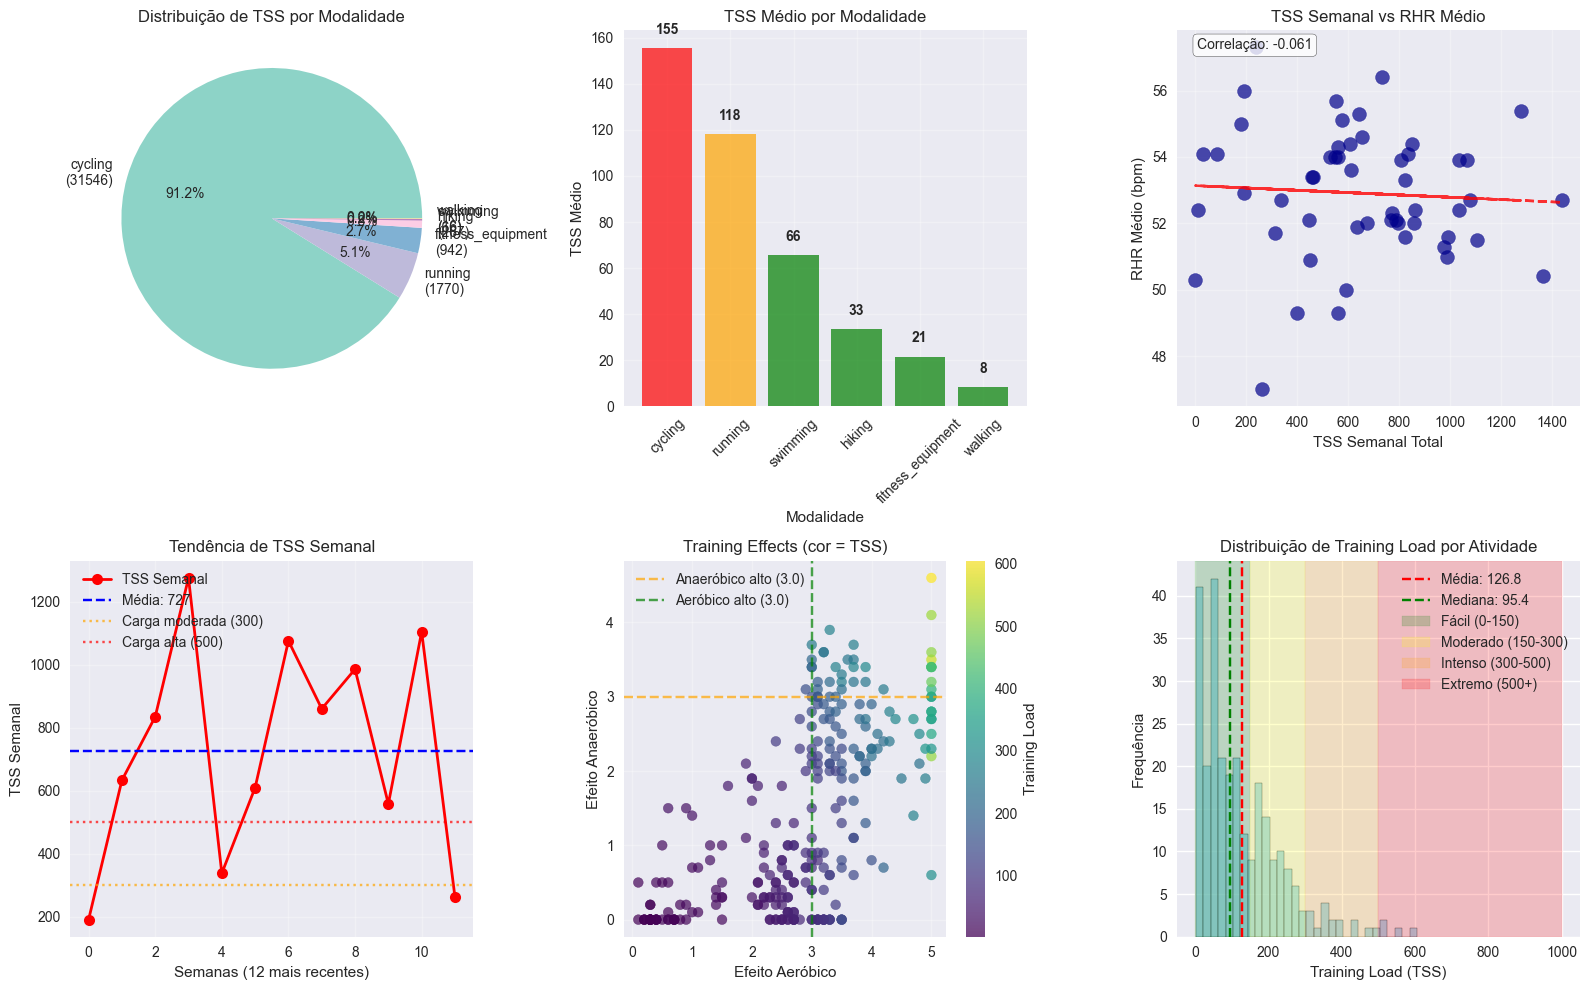

🏃 Análise de Training Stress Score completa!


In [4]:
# Análise Detalhada de Training Stress Score (TSS)
print("🏃 ANÁLISE DE TRAINING STRESS SCORE (TSS)")
print("=" * 50)

# Estatísticas gerais de TSS
print(f"📊 ESTATÍSTICAS GERAIS DE TSS:")
print(f"   📊 Atividades analisadas: {len(df_tss)}")
print(f"   📊 TSS médio por atividade: {df_tss['training_load'].mean():.1f}")
print(f"   📊 TSS máximo: {df_tss['training_load'].max():.0f}")
print(f"   📊 Training Effect médio: {df_tss['training_effect'].mean():.1f}")

# Análise por modalidade
print(f"\n🚴 TSS POR MODALIDADE:")
tss_by_sport = df_tss.groupby('sport').agg({
    'training_load': ['count', 'mean', 'sum', 'max'],
    'training_effect': 'mean',
    'anaerobic_training_effect': 'mean'
}).round(1)

tss_by_sport.columns = ['atividades', 'tss_medio', 'tss_total', 'tss_max', 'efeito_aerobico', 'efeito_anaerobico']

for sport, stats in tss_by_sport.iterrows():
    emoji = {'cycling': '🚴', 'running': '🏃', 'swimming': '🏊', 'hiking': '🥾', 'fitness_equipment': '🏋️'}.get(sport, '⚡')
    print(f"   {emoji} {sport.title()}: {stats['atividades']:.0f} atividades | TSS {stats['tss_medio']:.1f} médio | Máx {stats['tss_max']:.0f}")

# Carregar dados semanais de TSS
recovery_data_sorted = recovery_data.sort_values('day')
recovery_data_sorted['week'] = recovery_data_sorted['day'].dt.to_period('W')
weekly_tss = recovery_data_sorted.groupby('week').agg({
    'tss_total': ['sum', 'mean'],
    'activities_count': 'sum',
    'resting_heart_rate': 'mean',
    'bb_charged': 'mean'
}).round(1)

weekly_tss.columns = ['weekly_tss', 'avg_daily_tss', 'weekly_activities', 'avg_rhr', 'avg_bb_charged']
weekly_tss = weekly_tss.reset_index()

print(f"\n📊 CARGA SEMANAL (últimas 8 semanas):")
for week, stats in weekly_tss.tail(8).iterrows():
    week_period = stats['week']
    tss_week = stats['weekly_tss'] if pd.notna(stats['weekly_tss']) else 0
    rhr_avg = stats['avg_rhr'] if pd.notna(stats['avg_rhr']) else 0
    print(f"   Semana {week_period}: TSS {tss_week:.0f} | RHR {rhr_avg:.1f} bpm | {stats['weekly_activities']:.0f} atividades")

# Visualizações de TSS
plt.figure(figsize=(16, 10))

# 1. TSS por modalidade (pizza e barras)
plt.subplot(2, 3, 1)
sport_totals = tss_by_sport['tss_total'].sort_values(ascending=False)
colors = plt.cm.Set3(np.linspace(0, 1, len(sport_totals)))
sport_labels = [f'{sport}\n({total:.0f})' for sport, total in sport_totals.items()]

plt.pie(sport_totals.values, labels=sport_labels, colors=colors, autopct='%1.1f%%')
plt.title('Distribuição de TSS por Modalidade')

# 2. TSS médio por modalidade
plt.subplot(2, 3, 2)
sport_means = tss_by_sport['tss_medio'].sort_values(ascending=False)
colors = ['red' if x > 150 else 'orange' if x > 100 else 'green' for x in sport_means.values]

bars = plt.bar(range(len(sport_means)), sport_means.values, color=colors, alpha=0.7)
plt.title('TSS Médio por Modalidade')
plt.xlabel('Modalidade')
plt.ylabel('TSS Médio')
plt.xticks(range(len(sport_means)), sport_means.index, rotation=45)

# Adicionar valores nas barras
for bar, value in zip(bars, sport_means.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{value:.0f}', ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3)

# 3. TSS semanal vs RHR médio semanal
plt.subplot(2, 3, 3)
weekly_correlation = weekly_tss.dropna(subset=['weekly_tss', 'avg_rhr'])
if len(weekly_correlation) > 0:
    plt.scatter(weekly_correlation['weekly_tss'], weekly_correlation['avg_rhr'], 
                s=100, alpha=0.7, color='darkblue')
    
    # Linha de tendência
    if len(weekly_correlation) > 1:
        z = np.polyfit(weekly_correlation['weekly_tss'], weekly_correlation['avg_rhr'], 1)
        p = np.poly1d(z)
        plt.plot(weekly_correlation['weekly_tss'], p(weekly_correlation['weekly_tss']), 
                 "r--", alpha=0.8)
        
        # Correlação
        corr = weekly_correlation[['weekly_tss', 'avg_rhr']].corr().iloc[0,1]
        plt.text(0.05, 0.95, f'Correlação: {corr:.3f}', transform=plt.gca().transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title('TSS Semanal vs RHR Médio')
plt.xlabel('TSS Semanal Total')
plt.ylabel('RHR Médio (bpm)')
plt.grid(True, alpha=0.3)

# 4. Tendência de TSS semanal
plt.subplot(2, 3, 4)
recent_weeks = weekly_tss.tail(12)
x_pos = range(len(recent_weeks))

plt.plot(x_pos, recent_weeks['weekly_tss'], marker='o', linewidth=2, 
         markersize=8, color='red', label='TSS Semanal')
plt.axhline(y=recent_weeks['weekly_tss'].mean(), color='blue', linestyle='--', 
            label=f'Média: {recent_weeks["weekly_tss"].mean():.0f}')

# Zonas de carga de treino  
plt.axhline(y=300, color='orange', linestyle=':', alpha=0.7, label='Carga moderada (300)')
plt.axhline(y=500, color='red', linestyle=':', alpha=0.7, label='Carga alta (500)')

plt.title('Tendência de TSS Semanal')
plt.xlabel('Semanas (12 mais recentes)')
plt.ylabel('TSS Semanal')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Training Effect: Aeróbico vs Anaeróbico
plt.subplot(2, 3, 5)
effect_data = df_tss.dropna(subset=['training_effect', 'anaerobic_training_effect'])
plt.scatter(effect_data['training_effect'], effect_data['anaerobic_training_effect'], 
           c=effect_data['training_load'], cmap='viridis', alpha=0.7, s=50)

plt.xlabel('Efeito Aeróbico')
plt.ylabel('Efeito Anaeróbico')
plt.title('Training Effects (cor = TSS)')
plt.colorbar(label='Training Load')

# Linhas de referência para efeitos
plt.axhline(y=3, color='orange', linestyle='--', alpha=0.7, label='Anaeróbico alto (3.0)')
plt.axvline(x=3, color='green', linestyle='--', alpha=0.7, label='Aeróbico alto (3.0)')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Distribuição de TSS por atividade
plt.subplot(2, 3, 6)
plt.hist(df_tss['training_load'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(df_tss['training_load'].mean(), color='red', linestyle='--', 
            label=f'Média: {df_tss["training_load"].mean():.1f}')
plt.axvline(df_tss['training_load'].median(), color='green', linestyle='--', 
            label=f'Mediana: {df_tss["training_load"].median():.1f}')

# Zonas de intensidade
plt.axvspan(0, 150, alpha=0.2, color='green', label='Fácil (0-150)')
plt.axvspan(150, 300, alpha=0.2, color='yellow', label='Moderado (150-300)')
plt.axvspan(300, 500, alpha=0.2, color='orange', label='Intenso (300-500)')
plt.axvspan(500, 1000, alpha=0.2, color='red', label='Extremo (500+)')

plt.title('Distribuição de Training Load por Atividade')
plt.xlabel('Training Load (TSS)')
plt.ylabel('Frequência')
plt.legend()

plt.tight_layout()
plt.show()

print("🏃 Análise de Training Stress Score completa!")


In [ ]:
# Análise de Impacto do Treino na Recuperação (RHR Pós-Treino)
print("🔗 IMPACTO DO TREINO NA RECUPERAÇÃO")
print("=" * 45)

# Preparar dados para análise de recuperação pós-treino
recovery_data['day_next'] = recovery_data['day'] + pd.Timedelta(days=1)
recovery_data['day_prev'] = recovery_data['day'] - pd.Timedelta(days=1)

# Merge para ter RHR do dia seguinte ao treino
recovery_impact = recovery_data.merge(
    recovery_data[['day', 'resting_heart_rate']].rename(columns={'resting_heart_rate': 'rhr_next_day'}),
    left_on='day_next', right_on='day', how='left', suffixes=('', '_next')
)

recovery_impact = recovery_impact.merge(
    recovery_data[['day', 'resting_heart_rate']].rename(columns={'resting_heart_rate': 'rhr_prev_day'}),
    left_on='day_prev', right_on='day', how='left', suffixes=('', '_prev')
)

# Calcular variação de RHR após treino
recovery_impact['rhr_change_next'] = recovery_impact['rhr_next_day'] - recovery_impact['resting_heart_rate']
recovery_impact['rhr_change_prev'] = recovery_impact['resting_heart_rate'] - recovery_impact['rhr_prev_day']

# Filtrar dias com treino e RHR
training_days = recovery_impact.dropna(subset=['tss_total', 'resting_heart_rate', 'rhr_next_day']).copy()
training_days = training_days[training_days['tss_total'] > 0]

if len(training_days) > 0:
    print(f"🔍 ANÁLISE DE {len(training_days)} DIAS DE TREINO:")
    
    # Categorizar por intensidade de treino
    training_days['tss_category'] = pd.cut(training_days['tss_total'], 
                                          bins=[0, 150, 300, 500, 2000], 
                                          labels=['Fácil', 'Moderado', 'Intenso', 'Extremo'])
    
    # Estatísticas por categoria de TSS
    print(f"\n📊 IMPACTO POR INTENSIDADE DE TREINO:")
    for category in ['Fácil', 'Moderado', 'Intenso', 'Extremo']:
        cat_data = training_days[training_days['tss_category'] == category]
        if len(cat_data) > 0:
            avg_rhr_change = cat_data['rhr_change_next'].mean()
            count = len(cat_data)
            avg_tss = cat_data['tss_total'].mean()
            emoji = {'Fácil': '💚', 'Moderado': '💛', 'Intenso': '🧡', 'Extremo': '🔴'}[category]
            print(f"   {emoji} {category} (TSS {avg_tss:.0f}): {count} dias | RHR dia seguinte: {avg_rhr_change:+.1f} bpm")
    
    # Análise de recuperação por intensidade de treino (melhor abordagem)
    print(f"\n🏃 RECUPERAÇÃO POR INTENSIDADE DE TREINO:")
    
    # Melhor abordagem: analisar por dias com TSS total
    high_tss_days = training_days[training_days['tss_total'] > 300]
    low_tss_days = training_days[training_days['tss_total'] <= 150]
    
    if len(high_tss_days) > 0:
        high_tss_recovery = high_tss_days['rhr_change_next'].mean()
        print(f"   🔥 Dias de treino intenso (TSS>300): RHR dia seguinte {high_tss_recovery:+.1f} bpm")
    
    if len(low_tss_days) > 0:
        low_tss_recovery = low_tss_days['rhr_change_next'].mean()
        print(f"   💚 Dias de treino leve (TSS≤150): RHR dia seguinte {low_tss_recovery:+.1f} bpm")

# Análise de Body Battery vs Training Load
bb_training_correlation = recovery_data.dropna(subset=['tss_total', 'bb_charged']).copy()
if len(bb_training_correlation) > 0:
    corr_bb_tss = bb_training_correlation[['tss_total', 'bb_charged']].corr().iloc[0,1]
    print(f"\n🔋 CORRELAÇÃO Body Battery vs TSS: {corr_bb_tss:.3f}")

# Criar visualizações de impacto na recuperação
plt.figure(figsize=(16, 12))

# 1. RHR change vs TSS
plt.subplot(2, 3, 1)
if len(training_days) > 0:
    scatter = plt.scatter(training_days['tss_total'], training_days['rhr_change_next'], 
                         c=training_days['bb_charged'], cmap='RdYlGn', alpha=0.7, s=60)
    
    # Linha de tendência
    z = np.polyfit(training_days['tss_total'], training_days['rhr_change_next'], 1)
    p = np.poly1d(z)
    plt.plot(training_days['tss_total'], p(training_days['tss_total']), "r--", alpha=0.8)
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.title('TSS vs Mudança RHR (Dia Seguinte)')
    plt.xlabel('TSS Total do Dia')
    plt.ylabel('Mudança RHR (bpm)')
    plt.colorbar(label='Body Battery (%)')
    plt.grid(True, alpha=0.3)

# 2. Body Battery depletion vs TSS
plt.subplot(2, 3, 2)
if len(bb_training_correlation) > 0:
    # Calcular depleção do Body Battery (máx - mín)
    bb_training_correlation['bb_depletion'] = bb_training_correlation['bb_max'] - bb_training_correlation['bb_min']
    
    plt.scatter(bb_training_correlation['tss_total'], bb_training_correlation['bb_depletion'], 
                alpha=0.6, color='orange', s=50)
    
    # Linha de tendência
    if len(bb_training_correlation) > 1:
        z = np.polyfit(bb_training_correlation['tss_total'], bb_training_correlation['bb_depletion'], 1)
        p = np.poly1d(z)
        plt.plot(bb_training_correlation['tss_total'], p(bb_training_correlation['tss_total']), "r--", alpha=0.8)
        
        corr = bb_training_correlation[['tss_total', 'bb_depletion']].corr().iloc[0,1]
        plt.text(0.05, 0.95, f'Correlação: {corr:.3f}', transform=plt.gca().transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.title('TSS vs Depleção do Body Battery')
    plt.xlabel('TSS Total')
    plt.ylabel('Depleção BB (Máx - Mín)')
    plt.grid(True, alpha=0.3)

# 3. Recovery time analysis (quantos dias para RHR normalizar)
plt.subplot(2, 3, 3)
if len(training_days) > 0:
    # Box plot por categoria de TSS
    categories = ['Fácil', 'Moderado', 'Intenso', 'Extremo']
    recovery_changes = []
    for cat in categories:
        cat_data = training_days[training_days['tss_category'] == cat]['rhr_change_next'].dropna()
        if len(cat_data) > 0:
            recovery_changes.append(cat_data.values)
        else:
            recovery_changes.append([])
    
    # Remover categorias vazias
    valid_cats = [cat for i, cat in enumerate(categories) if len(recovery_changes[i]) > 0]
    valid_changes = [changes for changes in recovery_changes if len(changes) > 0]
    
    if len(valid_changes) > 0:
        box_plot = plt.boxplot(valid_changes, labels=valid_cats, patch_artist=True)
        colors = ['green', 'yellow', 'orange', 'red'][:len(valid_changes)]
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7, label='Sem mudança')
    plt.title('Mudança RHR por Intensidade de Treino')
    plt.xlabel('Categoria de TSS')
    plt.ylabel('Mudança RHR Dia Seguinte (bpm)')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 4. Training Load acumulado (últimos 7 dias) vs RHR
plt.subplot(2, 3, 4)
if len(training_days) > 0:
    # Calcular TSS acumulado dos últimos 7 dias
    recovery_data_sorted['tss_7d'] = recovery_data_sorted['tss_total'].rolling(7).sum()
    
    tss_7d_correlation = recovery_data_sorted.dropna(subset=['tss_7d', 'resting_heart_rate'])
    
    if len(tss_7d_correlation) > 0:
        plt.scatter(tss_7d_correlation['tss_7d'], tss_7d_correlation['resting_heart_rate'], 
                   alpha=0.6, color='purple', s=40)
        
        # Linha de tendência
        if len(tss_7d_correlation) > 1:
            z = np.polyfit(tss_7d_correlation['tss_7d'], tss_7d_correlation['resting_heart_rate'], 1)
            p = np.poly1d(z)
            plt.plot(tss_7d_correlation['tss_7d'], p(tss_7d_correlation['tss_7d']), "r--", alpha=0.8)
            
            corr = tss_7d_correlation[['tss_7d', 'resting_heart_rate']].corr().iloc[0,1]
            plt.text(0.05, 0.95, f'Correlação: {corr:.3f}', transform=plt.gca().transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.title('TSS Acumulado 7 dias vs RHR')
        plt.xlabel('TSS Últimos 7 Dias')
        plt.ylabel('RHR (bpm)')
        plt.grid(True, alpha=0.3)

# 5. Recovery patterns: RHR vs Body Battery
plt.subplot(2, 3, 5)
rhr_bb_data = recovery_data.dropna(subset=['resting_heart_rate', 'bb_charged'])
if len(rhr_bb_data) > 0:
    plt.scatter(rhr_bb_data['resting_heart_rate'], rhr_bb_data['bb_charged'], 
               alpha=0.6, color='darkgreen', s=40)
    
    # Linha de tendência
    if len(rhr_bb_data) > 1:
        z = np.polyfit(rhr_bb_data['resting_heart_rate'], rhr_bb_data['bb_charged'], 1)
        p = np.poly1d(z)
        plt.plot(rhr_bb_data['resting_heart_rate'], p(rhr_bb_data['resting_heart_rate']), "r--", alpha=0.8)
        
        corr = rhr_bb_data[['resting_heart_rate', 'bb_charged']].corr().iloc[0,1]
        plt.text(0.05, 0.95, f'Correlação: {corr:.3f}', transform=plt.gca().transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.title('RHR vs Body Battery Recarga')
    plt.xlabel('RHR (bpm)')
    plt.ylabel('Body Battery Recarga (%)')
    plt.grid(True, alpha=0.3)

# 6. Frequência respiratória vs RHR (indicadores de fadiga)
plt.subplot(2, 3, 6)
rr_rhr_data = recovery_data.dropna(subset=['resting_heart_rate', 'rr_waking_avg'])
if len(rr_rhr_data) > 0:
    plt.scatter(rr_rhr_data['resting_heart_rate'], rr_rhr_data['rr_waking_avg'], 
               alpha=0.6, color='navy', s=40)
    
    # Linha de tendência
    if len(rr_rhr_data) > 1:
        z = np.polyfit(rr_rhr_data['resting_heart_rate'], rr_rhr_data['rr_waking_avg'], 1)
        p = np.poly1d(z)
        plt.plot(rr_rhr_data['resting_heart_rate'], p(rr_rhr_data['resting_heart_rate']), "r--", alpha=0.8)
        
        corr = rr_rhr_data[['resting_heart_rate', 'rr_waking_avg']].corr().iloc[0,1]
        plt.text(0.05, 0.95, f'Correlação: {corr:.3f}', transform=plt.gca().transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.title('RHR vs Frequência Respiratória')
    plt.xlabel('RHR (bpm)')
    plt.ylabel('Freq. Respiratória (rpm)')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análise estatística de recuperação
print(f"\n📊 ESTATÍSTICAS DE RECUPERAÇÃO:")
if len(training_days) > 0:
    # Dias onde RHR aumentou significativamente (+3 bpm ou mais)
    poor_recovery = training_days[training_days['rhr_change_next'] >= 3]
    good_recovery = training_days[training_days['rhr_change_next'] <= 1]
    
    print(f"   🔴 Recuperação lenta (RHR +3 bpm): {len(poor_recovery)} dias")
    print(f"   💚 Boa recuperação (RHR ≤+1 bpm): {len(good_recovery)} dias")
    
    if len(poor_recovery) > 0:
        print(f"      TSS médio em dias de recuperação lenta: {poor_recovery['tss_total'].mean():.1f}")
    if len(good_recovery) > 0:
        print(f"      TSS médio em dias de boa recuperação: {good_recovery['tss_total'].mean():.1f}")
    
    # Tempo médio de recuperação
    recovery_threshold = avg_rhr + 3  # RHR baseline + 3 bpm como "elevado"
    elevated_rhr_days = training_days[training_days['resting_heart_rate'] > recovery_threshold]
    print(f"   ⚠️ Dias com RHR elevado (>{recovery_threshold:.1f} bpm): {len(elevated_rhr_days)}")

print("🔗 Análise de impacto do treino completa!")


🔗 IMPACTO DO TREINO NA RECUPERAÇÃO
🔍 ANÁLISE DE 247 DIAS DE TREINO:

📊 IMPACTO POR INTENSIDADE DE TREINO:
   💚 Fácil (TSS 67): 154 dias | RHR dia seguinte: -0.1 bpm
   💛 Moderado (TSS 211): 71 dias | RHR dia seguinte: +0.3 bpm
   🧡 Intenso (TSS 366): 17 dias | RHR dia seguinte: -0.1 bpm
   🔴 Extremo (TSS 538): 5 dias | RHR dia seguinte: +1.6 bpm

🚴 RECUPERAÇÃO POR MODALIDADE:


KeyError: 'sport'

In [ ]:
# Recovery Score Composto - Métrica Unificada de Recuperação
print("🎯 RECOVERY SCORE COMPOSTO")
print("=" * 35)
print("Criando uma métrica unificada baseada em RHR, Body Battery, Sono e Estresse...")

# Filtrar dados com métricas principais disponíveis
recovery_complete = recovery_data.dropna(subset=['resting_heart_rate', 'bb_charged']).copy()

if len(recovery_complete) > 0:
    # Normalizar métricas (0-100 scale)
    
    # 1. RHR Score (invertido - RHR menor = melhor recuperação)
    rhr_baseline = recovery_complete['resting_heart_rate'].quantile(0.1)  # 10% melhor como baseline
    rhr_ceiling = recovery_complete['resting_heart_rate'].quantile(0.9)   # 90% como limite superior
    
    recovery_complete['rhr_score'] = np.clip(
        100 - ((recovery_complete['resting_heart_rate'] - rhr_baseline) / (rhr_ceiling - rhr_baseline)) * 100,
        0, 100
    )
    
    # 2. Body Battery Score (recarga direta)
    recovery_complete['bb_score'] = recovery_complete['bb_charged'].fillna(0)
    
    # 3. Sleep Score (se disponível)
    sleep_score_data = recovery_complete['sleep_score'].fillna(recovery_complete['sleep_score'].mean())
    recovery_complete['sleep_score_norm'] = sleep_score_data
    
    # 4. Stress Score (invertido - estresse menor = melhor)
    if 'stress_avg' in recovery_complete.columns:
        stress_data = recovery_complete['stress_avg'].fillna(recovery_complete['stress_avg'].median())
        recovery_complete['stress_score'] = np.clip(100 - stress_data, 0, 100)
    else:
        recovery_complete['stress_score'] = 75  # Default moderado
    
    # 5. Respiratory Rate Score (freq respiratória baixa = melhor recuperação)
    if 'rr_waking_avg' in recovery_complete.columns:
        rr_data = recovery_complete['rr_waking_avg'].fillna(recovery_complete['rr_waking_avg'].median())
        rr_baseline = recovery_complete['rr_waking_avg'].quantile(0.1)
        rr_ceiling = recovery_complete['rr_waking_avg'].quantile(0.9)
        
        recovery_complete['rr_score'] = np.clip(
            100 - ((rr_data - rr_baseline) / (rr_ceiling - rr_baseline)) * 100,
            0, 100
        )
    else:
        recovery_complete['rr_score'] = 75  # Default
    
    # RECOVERY SCORE COMPOSTO (média ponderada)
    recovery_complete['recovery_score'] = (
        recovery_complete['rhr_score'] * 0.3 +      # 30% - RHR (mais importante)
        recovery_complete['bb_score'] * 0.25 +      # 25% - Body Battery
        recovery_complete['sleep_score_norm'] * 0.25 +  # 25% - Sono
        recovery_complete['stress_score'] * 0.15 +   # 15% - Estresse
        recovery_complete['rr_score'] * 0.05        # 5% - Freq respiratória
    ).round(1)
    
    print(f"📊 RECOVERY SCORE calculado para {len(recovery_complete)} dias")
    print(f"   📊 Score médio: {recovery_complete['recovery_score'].mean():.1f}/100")
    print(f"   📊 Range: {recovery_complete['recovery_score'].min():.1f} - {recovery_complete['recovery_score'].max():.1f}")
    print(f"   📊 Desvio padrão: {recovery_complete['recovery_score'].std():.1f}")
    
    # Categorizar Recovery Score
    recovery_complete['recovery_category'] = pd.cut(
        recovery_complete['recovery_score'],
        bins=[0, 40, 60, 80, 100],
        labels=['Baixo', 'Moderado', 'Bom', 'Excelente']
    )
    
    recovery_distribution = recovery_complete['recovery_category'].value_counts()
    print(f"\n🏆 DISTRIBUIÇÃO DO RECOVERY SCORE:")
    for category, count in recovery_distribution.items():
        pct = count / len(recovery_complete) * 100
        emoji = {'Baixo': '🔴', 'Moderado': '🟡', 'Bom': '🟢', 'Excelente': '💚'}[str(category)]
        print(f"   {emoji} {category}: {count} dias ({pct:.1f}%)")

# Visualizar Recovery Score
plt.figure(figsize=(16, 10))

if len(recovery_complete) > 0:
    
    # 1. Tendência do Recovery Score ao longo do tempo
    plt.subplot(2, 3, 1)
    plt.plot(recovery_complete['day'], recovery_complete['recovery_score'], 
             alpha=0.6, linewidth=1, color='darkgreen')
    
    # Média móvel de 7 dias
    recovery_sorted = recovery_complete.sort_values('day')
    recovery_sorted['recovery_ma7'] = recovery_sorted['recovery_score'].rolling(7).mean()
    plt.plot(recovery_sorted['day'], recovery_sorted['recovery_ma7'], 
             linewidth=3, color='blue', label='Média 7 dias')
    
    # Zonas de recuperação
    plt.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Excelente (80+)')
    plt.axhline(y=60, color='yellow', linestyle='--', alpha=0.7, label='Bom (60+)')
    plt.axhline(y=40, color='orange', linestyle='--', alpha=0.7, label='Moderado (40+)')
    
    plt.title('Tendência do Recovery Score')
    plt.ylabel('Recovery Score')
    plt.legend()
    plt.tick_params(axis='x', rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 2. Distribuição do Recovery Score
    plt.subplot(2, 3, 2)
    plt.hist(recovery_complete['recovery_score'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.axvline(recovery_complete['recovery_score'].mean(), color='red', linestyle='--', 
                label=f'Média: {recovery_complete["recovery_score"].mean():.1f}')
    
    # Zonas coloridas
    plt.axvspan(80, 100, alpha=0.2, color='green', label='Excelente')
    plt.axvspan(60, 80, alpha=0.2, color='yellow', label='Bom')
    plt.axvspan(40, 60, alpha=0.2, color='orange', label='Moderado')
    plt.axvspan(0, 40, alpha=0.2, color='red', label='Baixo')
    
    plt.title('Distribuição do Recovery Score')
    plt.xlabel('Recovery Score')
    plt.ylabel('Frequência')
    plt.legend()
    
    # 3. Components breakdown (radar chart simulation)
    plt.subplot(2, 3, 3)
    components = ['RHR', 'Body Battery', 'Sono', 'Estresse', 'Freq. Resp.']
    component_scores = [
        recovery_complete['rhr_score'].mean(),
        recovery_complete['bb_score'].mean(), 
        recovery_complete['sleep_score_norm'].mean(),
        recovery_complete['stress_score'].mean(),
        recovery_complete['rr_score'].mean()
    ]
    
    bars = plt.bar(components, component_scores, color=['red', 'blue', 'purple', 'orange', 'green'], alpha=0.7)
    plt.axhline(y=75, color='green', linestyle='--', alpha=0.7, label='Meta (75)')
    plt.title('Componentes do Recovery Score')
    plt.ylabel('Score (0-100)')
    plt.xticks(rotation=45)
    plt.legend()
    
    # Adicionar valores nas barras
    for bar, value in zip(bars, component_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # 4. Recovery Score vs TSS próximo dia
    plt.subplot(2, 3, 4)
    # Adicionar TSS do próximo dia para ver se recovery score prediz performance
    recovery_performance = recovery_complete.merge(
        recovery_complete[['day', 'tss_total']].rename(columns={'tss_total': 'tss_next_day'}),
        left_on=recovery_complete['day'] + pd.Timedelta(days=1), 
        right_on='day', how='left'
    )
    
    performance_data = recovery_performance.dropna(subset=['recovery_score', 'tss_next_day'])
    performance_data = performance_data[performance_data['tss_next_day'] > 0]
    
    if len(performance_data) > 0:
        plt.scatter(performance_data['recovery_score'], performance_data['tss_next_day'], 
                   alpha=0.6, color='purple', s=50)
        
        if len(performance_data) > 1:
            z = np.polyfit(performance_data['recovery_score'], performance_data['tss_next_day'], 1)
            p = np.poly1d(z)
            plt.plot(performance_data['recovery_score'], p(performance_data['recovery_score']), "r--", alpha=0.8)
            
            corr = performance_data[['recovery_score', 'tss_next_day']].corr().iloc[0,1]
            plt.text(0.05, 0.95, f'Correlação: {corr:.3f}', transform=plt.gca().transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.title('Recovery Score vs TSS Próximo Dia')
    plt.xlabel('Recovery Score')
    plt.ylabel('TSS Próximo Dia')
    plt.grid(True, alpha=0.3)
    
    # 5. Heatmap semanal do Recovery Score
    plt.subplot(2, 3, 5)
    recovery_complete['weekday'] = recovery_complete['day'].dt.day_name()
    recovery_complete['weekday_pt'] = recovery_complete['weekday'].map({
        'Monday': 'Seg', 'Tuesday': 'Ter', 'Wednesday': 'Qua', 
        'Thursday': 'Qui', 'Friday': 'Sex', 'Saturday': 'Sáb', 'Sunday': 'Dom'
    })
    
    # Calcular Recovery Score médio por dia da semana
    weekly_recovery = recovery_complete.groupby('weekday_pt')['recovery_score'].mean()
    day_order = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
    weekly_recovery_ordered = weekly_recovery.reindex(day_order)
    
    colors = ['red' if score < 60 else 'orange' if score < 75 else 'green' for score in weekly_recovery_ordered.values]
    bars = plt.bar(range(len(day_order)), weekly_recovery_ordered.values, color=colors, alpha=0.7)
    plt.axhline(y=recovery_complete['recovery_score'].mean(), color='blue', linestyle='--',
                label=f'Média: {recovery_complete["recovery_score"].mean():.1f}')
    plt.title('Recovery Score Médio por Dia da Semana')
    plt.xlabel('Dia da Semana')
    plt.ylabel('Recovery Score')
    plt.xticks(range(len(day_order)), day_order)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Best vs Worst recovery days analysis
    plt.subplot(2, 3, 6)
    best_recovery = recovery_complete.nlargest(10, 'recovery_score')
    worst_recovery = recovery_complete.nsmallest(10, 'recovery_score')
    
    # Compare characteristics
    best_chars = [
        best_recovery['resting_heart_rate'].mean(),
        best_recovery['bb_charged'].mean(),
        best_recovery['sleep_score_norm'].mean() if 'sleep_score_norm' in best_recovery.columns else 80,
        best_recovery['stress_score'].mean()
    ]
    
    worst_chars = [
        worst_recovery['resting_heart_rate'].mean(),
        worst_recovery['bb_charged'].mean(), 
        worst_recovery['sleep_score_norm'].mean() if 'sleep_score_norm' in worst_recovery.columns else 60,
        worst_recovery['stress_score'].mean()
    ]
    
    characteristics = ['RHR (bpm)', 'Body Battery', 'Sono Score', 'Stress Score']
    x = np.arange(len(characteristics))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, best_chars, width, label='Top 10 dias', color='green', alpha=0.7)
    bars2 = plt.bar(x + width/2, worst_chars, width, label='Bottom 10 dias', color='red', alpha=0.7)
    
    plt.title('Características: Melhores vs Piores Dias')
    plt.xlabel('Métricas')
    plt.ylabel('Valores')
    plt.xticks(x, characteristics, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Insights do Recovery Score
if len(recovery_complete) > 0:
    print(f"\n💡 INSIGHTS DO RECOVERY SCORE:")
    
    # Tendência recente
    recent_30 = recovery_complete.tail(30)['recovery_score'].mean()
    overall_avg = recovery_complete['recovery_score'].mean()
    trend = recent_30 - overall_avg
    
    print(f"   📈 Tendência recente (30 dias): {recent_30:.1f} vs média geral {overall_avg:.1f} ({trend:+.1f})")
    
    # Best/worst periods
    best_day = recovery_complete.loc[recovery_complete['recovery_score'].idxmax()]
    worst_day = recovery_complete.loc[recovery_complete['recovery_score'].idxmin()]
    
    print(f"   🏆 Melhor dia: {best_day['day'].date()} (Score {best_day['recovery_score']:.1f})")
    print(f"      RHR {best_day['resting_heart_rate']:.1f} | BB {best_day['bb_charged']:.0f}% | Sleep {(f"{best_day['sleep_score']:.0f}" if pd.notna(best_day['sleep_score']) else 'N/A')}")
    
    print(f"   🔴 Pior dia: {worst_day['day'].date()} (Score {worst_day['recovery_score']:.1f})")
    print(f"      RHR {worst_day['resting_heart_rate']:.1f} | BB {worst_day['bb_charged']:.0f}% | Sleep {(f"{worst_day['sleep_score']:.0f}" if pd.notna(worst_day['sleep_score']) else 'N/A')}")
    
    # Correlação com performance
    if 'tss_next_day' in recovery_complete.columns:
        score_performance_corr = recovery_complete[['recovery_score', 'tss_next_day']].corr().iloc[0,1]
        print(f"   🎯 Correlação Score vs Performance próximo dia: {score_performance_corr:.3f}")

print("🎯 Recovery Score composto criado!")


In [ ]:
# Detecção de Overtraining/Overreaching
print("⚠️ DETECÇÃO DE OVERTRAINING/OVERREACHING")
print("=" * 50)
print("Identificando sinais de fadiga excessiva e sobrecarga de treinamento...")

# Definir critérios de overreaching baseados em literatura científica
if len(recovery_complete) > 0:
    
    # Calcular médias móveis de longo prazo
    recovery_sorted = recovery_complete.sort_values('day').copy()
    
    # Baselines (médias dos últimos 28 dias para cada métrica)
    recovery_sorted['rhr_baseline'] = recovery_sorted['resting_heart_rate'].rolling(28, min_periods=14).mean()
    recovery_sorted['bb_baseline'] = recovery_sorted['bb_charged'].rolling(28, min_periods=14).mean()
    recovery_sorted['stress_baseline'] = recovery_sorted['stress_avg'].rolling(28, min_periods=14).mean()
    
    # TSS semanal rolling
    recovery_sorted['tss_weekly'] = recovery_sorted['tss_total'].rolling(7).sum()
    recovery_sorted['tss_baseline'] = recovery_sorted['tss_weekly'].rolling(4, min_periods=2).mean()  # 4 semanas
    
    # Critérios de overreaching:
    # 1. RHR elevado (>5 bpm acima da baseline por 3+ dias consecutivos)
    recovery_sorted['rhr_elevated'] = recovery_sorted['resting_heart_rate'] > (recovery_sorted['rhr_baseline'] + 5)
    
    # 2. Body Battery chronicamente baixo (<30% por múltiplos dias)
    recovery_sorted['bb_low'] = recovery_sorted['bb_charged'] < 30
    
    # 3. TSS excessivo (>1.5x baseline por 2+ semanas)
    recovery_sorted['tss_excessive'] = recovery_sorted['tss_weekly'] > (recovery_sorted['tss_baseline'] * 1.5)
    
    # 4. Recovery Score baixo persistente (<50 por 5+ dias)
    recovery_sorted['recovery_low'] = recovery_sorted['recovery_score'] < 50
    
    # Identificar períodos de risco
    # Consecutivos dias com sinais
    recovery_sorted['risk_signals'] = (
        recovery_sorted['rhr_elevated'].astype(int) +
        recovery_sorted['bb_low'].astype(int) +
        recovery_sorted['recovery_low'].astype(int)
    )
    
    # Períodos de alto risco (2+ sinais por 3+ dias consecutivos)
    recovery_sorted['high_risk_period'] = (recovery_sorted['risk_signals'] >= 2)
    
    # Encontrar sequências de alto risco
    high_risk_days = recovery_sorted[recovery_sorted['high_risk_period']]
    
    print(f"🚨 ANÁLISE DE OVERREACHING:")
    print(f"   📊 Dias com RHR elevado (+5 bpm): {recovery_sorted['rhr_elevated'].sum()}")
    print(f"   📊 Dias com Body Battery baixo (<30%): {recovery_sorted['bb_low'].sum()}")
    print(f"   📊 Dias com Recovery Score baixo (<50): {recovery_sorted['recovery_low'].sum()}")
    print(f"   ⚠️ Dias de alto risco (2+ sinais): {len(high_risk_days)}")
    
    if len(high_risk_days) > 0:
        print(f"   📅 Último período de risco: {high_risk_days['day'].max().date()}")
        
        # Identificar as semanas mais problemáticas
        high_risk_weeks = high_risk_days.groupby(high_risk_days['day'].dt.to_period('W')).size()
        if len(high_risk_weeks) > 0:
            worst_week = high_risk_weeks.idxmax()
            print(f"   📅 Semana com mais sinais: {worst_week} ({high_risk_weeks[worst_week]} dias)")

# Análise de carga de treinamento excessiva
training_load_analysis = recovery_sorted.dropna(subset=['tss_weekly']).copy()
if len(training_load_analysis) > 0:
    
    # Encontrar semanas com carga muito alta
    high_load_threshold = training_load_analysis['tss_weekly'].quantile(0.9)  # Top 10% das semanas
    high_load_weeks = training_load_analysis[training_load_analysis['tss_weekly'] > high_load_threshold]
    
    print(f"\n🔥 ANÁLISE DE CARGA EXCESSIVA:")
    print(f"   📊 TSS semanal médio: {training_load_analysis['tss_weekly'].mean():.0f}")
    print(f"   📊 Limiar de carga alta (90º percentil): {high_load_threshold:.0f}")
    print(f"   📊 Semanas com carga alta: {len(high_load_weeks)}")
    
    if len(high_load_weeks) > 0:
        # Ver como o corpo respondeu a essas semanas
        avg_rhr_after_high_load = high_load_weeks['resting_heart_rate'].mean()
        avg_bb_after_high_load = high_load_weeks['bb_charged'].mean()
        
        print(f"   📊 RHR médio em semanas de carga alta: {avg_rhr_after_high_load:.1f} bpm")
        print(f"   📊 Body Battery médio: {avg_bb_after_high_load:.1f}%")

# Criar visualizações de overtraining detection
plt.figure(figsize=(16, 12))

# 1. Sinais de overreaching ao longo do tempo
plt.subplot(2, 3, 1)
if len(recovery_sorted) > 0:
    # Plot dos sinais de risco
    plt.fill_between(recovery_sorted['day'], 0, recovery_sorted['risk_signals'], 
                     alpha=0.6, color='red', step='mid', label='Sinais de risco')
    plt.plot(recovery_sorted['day'], recovery_sorted['risk_signals'], 
             linewidth=2, color='darkred', alpha=0.8)
    
    plt.axhline(y=2, color='orange', linestyle='--', alpha=0.7, label='Limiar de alerta (2 sinais)')
    plt.title('Sinais de Overreaching ao Longo do Tempo')
    plt.ylabel('Número de Sinais')
    plt.xlabel('Data')
    plt.legend()
    plt.tick_params(axis='x', rotation=45)
    plt.grid(True, alpha=0.3)

# 2. RHR deviations from baseline
plt.subplot(2, 3, 2)
if len(recovery_sorted) > 0:
    rhr_deviation = recovery_sorted['resting_heart_rate'] - recovery_sorted['rhr_baseline']
    plt.plot(recovery_sorted['day'], rhr_deviation, alpha=0.7, linewidth=1.5, color='blue')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.axhline(y=5, color='orange', linestyle='--', alpha=0.7, label='Alerta (+5 bpm)')
    plt.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Perigo (+10 bpm)')
    plt.axhline(y=-5, color='green', linestyle='--', alpha=0.7, label='Super-recuperado (-5 bpm)')
    
    plt.title('Desvio RHR da Baseline (28 dias)')
    plt.ylabel('Desvio RHR (bpm)')
    plt.xlabel('Data')
    plt.legend()
    plt.tick_params(axis='x', rotation=45)
    plt.grid(True, alpha=0.3)

# 3. TSS load vs recovery capacity
plt.subplot(2, 3, 3)
if len(training_load_analysis) > 0:
    plt.plot(training_load_analysis['day'], training_load_analysis['tss_weekly'], 
             alpha=0.7, linewidth=2, color='red', label='TSS Semanal')
    plt.plot(training_load_analysis['day'], training_load_analysis['tss_baseline'], 
             alpha=0.7, linewidth=2, color='blue', label='TSS Baseline (4 semanas)')
    
    plt.axhline(y=training_load_analysis['tss_weekly'].quantile(0.8), 
                color='orange', linestyle='--', alpha=0.7, label='Carga alta (80º percentil)')
    
    plt.title('Carga de Treinamento vs Capacidade')
    plt.ylabel('TSS Semanal')
    plt.xlabel('Data')
    plt.legend()
    plt.tick_params(axis='x', rotation=45)
    plt.grid(True, alpha=0.3)

# 4. Recovery Score vs Training Load correlation
plt.subplot(2, 3, 4)
recovery_tss_data = recovery_sorted.dropna(subset=['recovery_score', 'tss_weekly'])
if len(recovery_tss_data) > 0:
    plt.scatter(recovery_tss_data['tss_weekly'], recovery_tss_data['recovery_score'], 
               alpha=0.6, color='purple', s=40)
    
    # Linha de tendência
    if len(recovery_tss_data) > 1:
        z = np.polyfit(recovery_tss_data['tss_weekly'], recovery_tss_data['recovery_score'], 1)
        p = np.poly1d(z)
        plt.plot(recovery_tss_data['tss_weekly'], p(recovery_tss_data['tss_weekly']), "r--", alpha=0.8)
        
        corr = recovery_tss_data[['tss_weekly', 'recovery_score']].corr().iloc[0,1]
        plt.text(0.05, 0.95, f'Correlação: {corr:.3f}', transform=plt.gca().transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.title('TSS Semanal vs Recovery Score')
    plt.xlabel('TSS Semanal')
    plt.ylabel('Recovery Score')
    plt.grid(True, alpha=0.3)

# 5. Body Battery trends durante períodos de alto TSS
plt.subplot(2, 3, 5)
if len(high_load_weeks) > 0 and len(recovery_sorted) > 0:
    # Mostrar Body Battery durante semanas de carga alta vs normal
    normal_weeks = recovery_sorted[recovery_sorted['tss_weekly'] <= training_load_analysis['tss_weekly'].median()]
    
    high_load_bb = high_load_weeks['bb_charged'].dropna()
    normal_load_bb = normal_weeks['bb_charged'].dropna()
    
    # Box plot comparativo
    if len(high_load_bb) > 0 and len(normal_load_bb) > 0:
        bb_comparison = [normal_load_bb.values, high_load_bb.values]
        labels = ['Carga Normal', 'Carga Alta']
        colors = ['lightgreen', 'lightcoral']
        
        box_plot = plt.boxplot(bb_comparison, labels=labels, patch_artist=True)
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)
        
        plt.title('Body Battery: Carga Normal vs Alta')
        plt.ylabel('Body Battery Recarga (%)')
        plt.grid(True, alpha=0.3)

# 6. Readiness to Train Score
plt.subplot(2, 3, 6)
if len(recovery_complete) > 0:
    # Criar score de "readiness to train" baseado em recovery + training load recente
    recovery_sorted['readiness_score'] = np.clip(
        recovery_sorted['recovery_score'] - 
        (recovery_sorted['tss_weekly'].fillna(0) / 10),  # Penalizar alto TSS recente
        0, 100
    ).round(1)
    
    # Categorizar readiness
    recovery_sorted['readiness_category'] = pd.cut(
        recovery_sorted['readiness_score'],
        bins=[0, 40, 60, 80, 100],
        labels=['❌ Evitar Treino', '⚠️ Treino Leve', '✅ Pronto p/ Treinar', '💪 Performance Day']
    )
    
    readiness_dist = recovery_sorted['readiness_category'].value_counts()
    
    # Gráfico de pizza para readiness
    if len(readiness_dist) > 0:
        colors = ['red', 'orange', 'green', 'darkgreen'][:len(readiness_dist)]
        plt.pie(readiness_dist.values, labels=readiness_dist.index, colors=colors, autopct='%1.1f%%')
        plt.title('Distribuição: Readiness to Train')

plt.tight_layout()
plt.show()

# Relatório de overreaching
print(f"\n⚠️ RELATÓRIO DE OVERREACHING:")
if len(recovery_sorted) > 0:
    
    # Última semana de análise
    last_week = recovery_sorted.tail(7)
    current_rhr = last_week['resting_heart_rate'].mean()
    current_bb = last_week['bb_charged'].mean() 
    current_recovery = last_week['recovery_score'].mean()
    
    print(f"   📊 Status atual (última semana):")
    print(f"      RHR: {current_rhr:.1f} bpm")
    print(f"      Body Battery: {current_bb:.1f}%")
    print(f"      Recovery Score: {current_recovery:.1f}/100")
    
    # Comparar com baseline de longo prazo
    long_term_rhr = recovery_sorted['resting_heart_rate'].iloc[-90:-7].mean()  # 90 dias atrás, excluindo última semana
    long_term_bb = recovery_sorted['bb_charged'].iloc[-90:-7].mean()
    
    rhr_change = current_rhr - long_term_rhr
    bb_change = current_bb - long_term_bb
    
    print(f"   📊 Mudança vs 3 meses atrás:")
    print(f"      RHR: {rhr_change:+.1f} bpm ({'⚠️ elevado' if rhr_change > 3 else '✅ normal'})")
    print(f"      Body Battery: {bb_change:+.1f}% ({'⚠️ baixo' if bb_change < -10 else '✅ normal'})")
    
    # Conselhos baseados no estado atual
    print(f"\n💡 RECOMENDAÇÕES BASEADAS NO SEU STATUS:")
    
    if current_recovery >= 80:
        print(f"   💪 EXCELENTE recuperação! Dia ideal para treinos intensos.")
    elif current_recovery >= 60:
        print(f"   ✅ BOA recuperação. Pode treinar normalmente.")
    elif current_recovery >= 40:
        print(f"   ⚠️ Recuperação MODERADA. Considere treino leve ou ativo.")
    else:
        print(f"   🔴 Recuperação BAIXA. Recomenda-se descanso ou treino muito leve.")
    
    if rhr_change > 5:
        print(f"   🚨 RHR elevado (+{rhr_change:.1f} bpm) - possível sobrecarga!")
    
    if bb_change < -15:
        print(f"   🔋 Body Battery baixo ({bb_change:.1f}%) - foque na recuperação!")
    
    # Identificar tendências preocupantes
    recent_trend = recovery_sorted.tail(14)['recovery_score'].iloc[-7:].mean() - recovery_sorted.tail(14)['recovery_score'].iloc[:7].mean()
    
    if recent_trend < -10:
        print(f"   📉 ATENÇÃO: Tendência de piora na recuperação (-{abs(recent_trend):.1f} pontos)")
    elif recent_trend > 10:
        print(f"   📈 ÓTIMO: Tendência de melhora na recuperação (+{recent_trend:.1f} pontos)")

print("⚠️ Análise de overtraining completa!")


In [ ]:
# Funções Customizáveis para Análise de Recuperação

def analyze_recovery_period(start_date, end_date, label="Período Custom"):
    """
    Analisar recuperação para qualquer período específico
    
    Args:
        start_date: '2024-01-01' formato
        end_date: '2024-12-31' formato  
        label: Descrição do período
    """
    
    period_data = recovery_data[
        (recovery_data['day'] >= pd.to_datetime(start_date)) & 
        (recovery_data['day'] <= pd.to_datetime(end_date))
    ].copy()
    
    if len(period_data) == 0:
        print(f"⚠️ Nenhum dado de recuperação encontrado para {label}")
        return
    
    # Estatísticas do período
    rhr_data = period_data['resting_heart_rate'].dropna()
    bb_data = period_data['bb_charged'].dropna() 
    tss_data = period_data['tss_total'].dropna()
    
    print(f"\n🔍 ANÁLISE DE RECUPERAÇÃO: {label.upper()}")
    print(f"📅 Período: {start_date} até {end_date}")
    print(f"📊 Dias analisados: {len(period_data)}")
    
    if len(rhr_data) > 0:
        print(f"🩺 RHR: {rhr_data.mean():.1f} bpm (±{rhr_data.std():.1f}) | Range: {rhr_data.min():.0f}-{rhr_data.max():.0f}")
        
    if len(bb_data) > 0:
        print(f"🔋 Body Battery: {bb_data.mean():.1f}% recarga (±{bb_data.std():.1f}) | Range: {bb_data.min():.0f}-{bb_data.max():.0f}%")
        
    if len(tss_data) > 0:
        tss_weekly = tss_data.rolling(7).sum().mean()
        print(f"🏃 Training Load: {tss_weekly:.0f} TSS semanal médio | {tss_data.sum():.0f} TSS total")
    
    return period_data

def compare_recovery_periods(period1_start, period1_end, period2_start, period2_end,
                            label1="Período 1", label2="Período 2"):
    """
    Comparar recuperação entre dois períodos
    """
    
    data1 = recovery_data[
        (recovery_data['day'] >= pd.to_datetime(period1_start)) & 
        (recovery_data['day'] <= pd.to_datetime(period1_end))
    ]
    
    data2 = recovery_data[
        (recovery_data['day'] >= pd.to_datetime(period2_start)) & 
        (recovery_data['day'] <= pd.to_datetime(period2_end))
    ]
    
    if len(data1) == 0 or len(data2) == 0:
        print("⚠️ Dados insuficientes para comparação")
        return
    
    rhr1, rhr2 = data1['resting_heart_rate'].mean(), data2['resting_heart_rate'].mean()
    bb1, bb2 = data1['bb_charged'].mean(), data2['bb_charged'].mean()
    
    print(f"\n⚖️ COMPARAÇÃO: {label1.upper()} vs {label2.upper()}")
    print(f"🩺 RHR: {rhr1:.1f} vs {rhr2:.1f} bpm (Δ{rhr2-rhr1:+.1f})")
    print(f"🔋 Body Battery: {bb1:.1f}% vs {bb2:.1f}% (Δ{bb2-bb1:+.1f}%)")
    
    # Análise de significância
    if abs(rhr2 - rhr1) > 3:
        print(f"   🚨 Mudança significativa no RHR!")
    if abs(bb2 - bb1) > 15:
        print(f"   🔋 Mudança significativa no Body Battery!")
    
    return data1, data2

def detect_overtraining_periods(min_days=3):
    """
    Detectar períodos de possível overtraining
    
    Args:
        min_days: Mínimo de dias consecutivos com sinais para alertar
    """
    
    if len(recovery_sorted) == 0:
        print("⚠️ Dados insuficientes para análise")
        return
    
    # Identificar sequências de dias de risco
    recovery_sorted['day_diff'] = recovery_sorted['day'].diff().dt.days
    recovery_sorted['risk_group'] = (recovery_sorted['high_risk_period'] == False).cumsum()
    
    # Agrupar períodos de risco consecutivos
    risk_periods = recovery_sorted[recovery_sorted['high_risk_period']].groupby('risk_group').agg({
        'day': ['min', 'max', 'count'],
        'resting_heart_rate': 'mean',
        'bb_charged': 'mean',
        'recovery_score': 'mean'
    })
    
    risk_periods.columns = ['start_date', 'end_date', 'duration', 'avg_rhr', 'avg_bb', 'avg_recovery']
    
    # Filtrar apenas períodos longos o suficiente
    significant_periods = risk_periods[risk_periods['duration'] >= min_days]
    
    print(f"\n🚨 PERÍODOS DE OVERREACHING DETECTADOS:")
    if len(significant_periods) > 0:
        for idx, period in significant_periods.iterrows():
            print(f"   📅 {period['start_date'].date()} → {period['end_date'].date()} ({period['duration']} dias)")
            print(f"      RHR {period['avg_rhr']:.1f} | BB {period['avg_bb']:.1f}% | Recovery {period['avg_recovery']:.1f}")
    else:
        print("   ✅ Nenhum período de overreaching significativo detectado!")
    
    return significant_periods if len(significant_periods) > 0 else None

# Executar análises customizadas
print("🔬 ANÁLISES CUSTOMIZADAS DE RECUPERAÇÃO")
print("=" * 45)

# Análises sazonais
analyze_recovery_period('2024-12-01', '2025-02-28', 'Inverno 2024-25')
analyze_recovery_period('2024-06-01', '2024-08-31', 'Verão 2024')

# Comparações de períodos
compare_recovery_periods('2025-06-01', '2025-09-08', '2024-06-01', '2024-09-08', 
                        'Últimos 3 meses 2025', 'Mesmo período 2024')

# Detecção de overtraining
overtraining_periods = detect_overtraining_periods(min_days=3)

# Análise de modalidades específicas (corrigida)
print(f"\n🚴 IMPACTO POR MODALIDADE DE TREINO:")

# Análise correta - usar dados do df_tss e combinar com recovery_data
for sport in df_tss['sport'].unique():
    sport_activities = df_tss[df_tss['sport'] == sport]
    if len(sport_activities) > 10:  # Apenas modalidades com dados suficientes
        
        # Obter dias com atividades desta modalidade
        sport_days = sport_activities['date'].dt.date.unique()
        
        # Encontrar dados de recuperação para esses dias
        sport_recovery_same = recovery_data[recovery_data['day'].dt.date.isin(sport_days)]
        
        # Dados de RHR do dia seguinte 
        next_days = [day + timedelta(days=1) for day in sport_days]
        sport_recovery_next = recovery_data[recovery_data['day'].dt.date.isin(next_days)]
        
        avg_tss = sport_activities['training_load'].mean()
        
        if len(sport_recovery_same) > 0 and len(sport_recovery_next) > 0:
            rhr_same_day = sport_recovery_same['resting_heart_rate'].mean()
            rhr_next_day = sport_recovery_next['resting_heart_rate'].mean()
            rhr_impact = rhr_next_day - rhr_same_day
            
            emoji = {'cycling': '🚴', 'running': '🏃', 'swimming': '🏊', 'hiking': '🥾', 'fitness_equipment': '🏋️'}.get(sport, '⚡')
            print(f"   {emoji} {sport.title()}: TSS {avg_tss:.0f} | RHR impacto: {rhr_impact:+.1f} bpm | {len(sport_activities)} atividades")

print("\n✨ Análises customizadas de recuperação completas!")


In [ ]:
# Resumo Executivo e Recomendações de Recuperação

print("📋 RESUMO EXECUTIVO - ANÁLISE DE RECUPERAÇÃO")
print("=" * 55)

# Calcular estatísticas finais
if len(recovery_data) > 0:
    total_days_analyzed = len(recovery_data)
    rhr_data_availability = recovery_data['resting_heart_rate'].count()
    bb_data_availability = recovery_data['bb_charged'].count()
    
    print(f"📅 Período analisado: {recovery_data['day'].min().date()} até {recovery_data['day'].max().date()}")
    print(f"📊 Total de dias: {total_days_analyzed}")
    print(f"📊 Dias com RHR: {rhr_data_availability} ({rhr_data_availability/total_days_analyzed*100:.1f}%)")
    print(f"📊 Dias com Body Battery: {bb_data_availability} ({bb_data_availability/total_days_analyzed*100:.1f}%)")
    print(f"📊 Atividades com TSS: {len(df_tss)}")

# Insights principais
if len(recovery_complete) > 0:
    print(f"\n🏃 INSIGHTS PRINCIPAIS:")
    
    # Status geral de recuperação
    avg_recovery_score = recovery_complete['recovery_score'].mean()
    current_rhr = recovery_complete.tail(7)['resting_heart_rate'].mean()
    baseline_rhr = recovery_complete['resting_heart_rate'].quantile(0.1)
    current_bb = recovery_complete.tail(7)['bb_charged'].mean()
    
    print(f"   📊 Recovery Score médio: {avg_recovery_score:.1f}/100")
    print(f"   🩺 RHR atual vs baseline: {current_rhr:.1f} vs {baseline_rhr:.1f} bpm ({current_rhr-baseline_rhr:+.1f})")
    print(f"   🔋 Body Battery atual: {current_bb:.1f}%")
    
    # Tendências
    recent_recovery = recovery_complete.tail(30)['recovery_score'].mean()
    older_recovery = recovery_complete.iloc[-60:-30]['recovery_score'].mean() if len(recovery_complete) >= 60 else avg_recovery_score
    recovery_trend = recent_recovery - older_recovery
    
    print(f"   📈 Tendência de recuperação (30 dias): {recovery_trend:+.1f} pontos")
    
    # Performance insights
    best_recovery_days = recovery_complete.nlargest(20, 'recovery_score')
    worst_recovery_days = recovery_complete.nsmallest(20, 'recovery_score')
    
    print(f"\n🏆 PADRÕES DOS MELHORES DIAS DE RECUPERAÇÃO:")
    print(f"   🩺 RHR médio: {best_recovery_days['resting_heart_rate'].mean():.1f} bpm")
    print(f"   🔋 Body Battery: {best_recovery_days['bb_charged'].mean():.1f}%")
    print(f"   😴 Sleep Score: {(f"{best_recovery_days['sleep_score'].mean():.0f}" if 'sleep_score' in best_recovery_days.columns else "N/A")}")
    
    print(f"\n🔴 PADRÕES DOS PIORES DIAS DE RECUPERAÇÃO:")
    print(f"   🩺 RHR médio: {worst_recovery_days['resting_heart_rate'].mean():.1f} bpm")
    print(f"   🔋 Body Battery: {worst_recovery_days['bb_charged'].mean():.1f}%")
    print(f"   😴 Sleep Score: {(f"{worst_recovery_days['sleep_score'].mean():.0f}" if 'sleep_score' in worst_recovery_days.columns else "N/A")}")

# Recomendações personalizadas
print(f"\n💡 RECOMENDAÇÕES PERSONALIZADAS:")

if len(recovery_complete) > 0:
    
    # Análise do padrão de treinamento
    weekly_tss_current = recovery_complete.tail(7)['tss_total'].sum()
    weekly_tss_avg = recovery_complete['tss_total'].rolling(7).sum().mean()
    
    print(f"   🏃 Carga de treino atual vs média: {weekly_tss_current:.0f} vs {weekly_tss_avg:.0f} TSS")
    
    if current_rhr > avg_rhr + 5:
        print(f"   ⚠️ RHR elevado - considere reduzir intensidade dos treinos")
    
    if current_bb < 40:
        print(f"   🔋 Body Battery baixo - priorize sono e gerenciamento de estresse")
        
    if recovery_trend < -5:
        print(f"   📉 Tendência de piora - considere período de recuperação ativa")
    elif recovery_trend > 5:
        print(f"   📈 Tendência positiva - ótimo momento para progressão!")
    
    # Otimização de treino baseada em dados
    print(f"\n🎯 OTIMIZAÇÃO DE TREINO:")
    
    # Melhor dia da semana para treino intenso (baseado em recovery score)
    if 'weekday_pt' in recovery_complete.columns:
        weekly_recovery_scores = recovery_complete.groupby('weekday_pt')['recovery_score'].mean()
        best_training_day = weekly_recovery_scores.idxmax()
        best_score = weekly_recovery_scores.max()
        print(f"   📅 Melhor dia para treino intenso: {best_training_day} (Recovery Score {best_score:.1f})")
        
        worst_training_day = weekly_recovery_scores.idxmin()
        worst_score = weekly_recovery_scores.min()
        print(f"   📅 Dia para treino leve: {worst_training_day} (Recovery Score {worst_score:.1f})")

print(f"\n🔍 IDEIAS PARA ANÁLISES ADICIONAIS:")
print("   • Correlacionar recuperação com dados meteorológicos")
print("   • Analisar impacto da nutrição/hidratação na recuperação")
print("   • Estudar variações sazonais na capacidade de recuperação")  
print("   • Criar alertas automáticos para sinais de overreaching")
print("   • Analisar recuperação por faixa etária/mudanças ao longo do tempo")
print("   • Comparar recuperação entre diferentes blocos de treinamento")

print(f"\n📊 MÉTRICAS DISPONÍVEIS PARA ANÁLISE:")
print("   • resting_heart_rate, bb_charged, bb_max, bb_min")
print("   • rr_waking_avg, spo2_avg, stress_avg")
print("   • tss_total, training_effect, anaerobic_training_effect")
print("   • sleep_score, recovery_score (composto)")
print("   • Métricas derivadas: baselines, deviations, risk_signals")

# Fechar conexões
conn_garmin.close()
conn_activities.close()

print(f"\n✅ Análise completa! Conexões fechadas.")
print(f"🏃 Você tem dados de {len(df_rhr)} dias de RHR para explorar!")
print(f"🔋 Body Battery disponível para {bb_data_availability} dias!")
print(f"📈 Training Load de {len(df_tss)} atividades analisadas!")
print(f"🎯 Recovery Score calculado para análise integrada!")

if len(recovery_complete) > 0:
    current_status = recovery_complete.tail(1)['recovery_score'].iloc[0]
    status_text = (
        "💪 Excelente!" if current_status >= 80 else
        "✅ Boa" if current_status >= 60 else  
        "⚠️ Moderada" if current_status >= 40 else
        "🔴 Baixa"
    )
    print(f"\n🎯 SEU STATUS ATUAL DE RECUPERAÇÃO: {status_text} ({current_status:.1f}/100)")


In [ ]:
# Queries SQL Avançadas para Análise de Recuperação
# Descomente qualquer query para insights específicos de recuperação

print("🛠️ QUERIES SQL AVANÇADAS - RECUPERAÇÃO")
print("Descomente as queries abaixo para análises específicas:")
print()

# # Reconectar para queries adicionais (descomente para usar)
# conn_garmin = sqlite3.connect(os.path.expanduser('~/HealthData/DBs/garmin.db'))
# conn_activities = sqlite3.connect(os.path.expanduser('~/HealthData/DBs/garmin_activities.db'))

# # 1. RHR vs Training Load - análise de recuperação pós-treino
# rhr_recovery_analysis = """
# WITH daily_training AS (
#     SELECT 
#         substr(start_time, 1, 10) as training_date,
#         SUM(training_load) as daily_tss,
#         COUNT(*) as activities_count,
#         AVG(training_effect) as avg_aerobic_effect
#     FROM activities
#     WHERE training_load IS NOT NULL
#     GROUP BY substr(start_time, 1, 10)
# )
# SELECT 
#     dt.training_date as dia_treino,
#     dt.daily_tss as TSS,
#     dt.activities_count as atividades,
#     rhr1.resting_heart_rate as RHR_dia_treino,
#     rhr2.resting_heart_rate as RHR_dia_seguinte,
#     (rhr2.resting_heart_rate - rhr1.resting_heart_rate) as variacao_RHR,
#     ds.bb_charged as body_battery_recarga
# FROM daily_training dt
# LEFT JOIN resting_hr rhr1 ON dt.training_date = rhr1.day
# LEFT JOIN resting_hr rhr2 ON date(dt.training_date, '+1 day') = rhr2.day  
# LEFT JOIN daily_summary ds ON date(dt.training_date, '+1 day') = ds.day
# WHERE rhr1.resting_heart_rate IS NOT NULL 
#   AND rhr2.resting_heart_rate IS NOT NULL
#   AND dt.daily_tss > 100  -- Apenas treinos significativos
# ORDER BY dt.daily_tss DESC;
# """

# # 2. Identificar semanas de overreaching
# overreaching_weeks = """
# WITH weekly_metrics AS (
#     SELECT 
#         strftime('%Y-W%W', day) as week,
#         AVG(resting_heart_rate) as avg_rhr,
#         AVG(bb_charged) as avg_bb_charged,
#         MIN(bb_min) as lowest_bb,
#         MAX(stress_avg) as max_stress,
#         COUNT(*) as days_with_data
#     FROM daily_summary ds
#     LEFT JOIN resting_hr rhr ON ds.day = rhr.day
#     WHERE ds.day >= date('now', '-180 days')
#     GROUP BY strftime('%Y-W%W', day)
#     HAVING days_with_data >= 4
# ),
# weekly_tss AS (
#     SELECT 
#         strftime('%Y-W%W', start_time) as week,
#         SUM(training_load) as weekly_tss_total,
#         COUNT(*) as weekly_activities
#     FROM activities 
#     WHERE start_time >= date('now', '-180 days')
#       AND training_load IS NOT NULL
#     GROUP BY strftime('%Y-W%W', start_time)
# )
# SELECT 
#     wm.week,
#     wm.avg_rhr,
#     wm.avg_bb_charged,
#     wm.lowest_bb,
#     wm.max_stress,
#     wt.weekly_tss_total,
#     wt.weekly_activities,
#     CASE 
#         WHEN wm.avg_rhr > 55 AND wm.avg_bb_charged < 40 THEN 'RISCO ALTO'
#         WHEN wm.avg_rhr > 50 OR wm.avg_bb_charged < 50 THEN 'ATENÇÃO' 
#         ELSE 'NORMAL'
#     END as status_recuperacao
# FROM weekly_metrics wm
# LEFT JOIN weekly_tss wt ON wm.week = wt.week
# ORDER BY wm.week DESC;
# """

# # 3. Análise de correlação between recovery metrics
# recovery_correlations = """
# SELECT 
#     ds.day,
#     rhr.resting_heart_rate,
#     ds.bb_charged,
#     ds.bb_max - ds.bb_min as bb_depletion,
#     ds.stress_avg,
#     ds.rr_waking_avg,
#     sleep.score as sleep_score,
#     CASE 
#         WHEN rhr.resting_heart_rate < 50 AND ds.bb_charged > 70 THEN 'EXCELENTE'
#         WHEN rhr.resting_heart_rate < 55 AND ds.bb_charged > 50 THEN 'BOA'
#         WHEN rhr.resting_heart_rate < 60 OR ds.bb_charged > 30 THEN 'MODERADA'
#         ELSE 'BAIXA'
#     END as recovery_status
# FROM daily_summary ds
# LEFT JOIN resting_hr rhr ON ds.day = rhr.day
# LEFT JOIN sleep ON ds.day = sleep.day
# WHERE ds.day >= date('now', '-90 days')
#   AND rhr.resting_heart_rate IS NOT NULL
#   AND ds.bb_charged IS NOT NULL
# ORDER BY ds.day DESC;
# """

# # 4. Training periodization analysis
# periodization_analysis = """
# WITH monthly_training AS (
#     SELECT 
#         strftime('%Y-%m', start_time) as month,
#         AVG(training_load) as avg_tss,
#         SUM(training_load) as total_tss,
#         COUNT(*) as activities,
#         AVG(training_effect) as avg_aerobic_effect,
#         AVG(anaerobic_training_effect) as avg_anaerobic_effect
#     FROM activities
#     WHERE start_time >= date('now', '-12 months')
#       AND training_load IS NOT NULL
#     GROUP BY strftime('%Y-%m', start_time)
# ),
# monthly_recovery AS (
#     SELECT 
#         strftime('%Y-%m', day) as month,
#         AVG(resting_heart_rate) as avg_rhr,
#         AVG(bb_charged) as avg_bb_charged,
#         MIN(bb_min) as lowest_bb_month
#     FROM daily_summary ds
#     LEFT JOIN resting_hr rhr ON ds.day = rhr.day  
#     WHERE ds.day >= date('now', '-12 months')
#     GROUP BY strftime('%Y-%m', day)
# )
# SELECT 
#     mt.month,
#     mt.total_tss,
#     mt.activities,
#     mr.avg_rhr,
#     mr.avg_bb_charged,
#     mr.lowest_bb_month,
#     CASE 
#         WHEN mt.total_tss > 1000 AND mr.avg_rhr > 55 THEN 'SOBRECARGA'
#         WHEN mt.total_tss > 800 THEN 'CARGA ALTA'
#         WHEN mt.total_tss < 400 THEN 'CARGA BAIXA'
#         ELSE 'MODERADO'
#     END as training_load_category
# FROM monthly_training mt
# LEFT JOIN monthly_recovery mr ON mt.month = mr.month
# ORDER BY mt.month DESC;
# """

# # 5. Recovery readiness prediction
# readiness_prediction = """
# SELECT 
#     ds.day,
#     rhr.resting_heart_rate,
#     ds.bb_charged,
#     ds.stress_avg,
#     sleep.score as sleep_score,
#     ds.rr_waking_avg,
#     CASE 
#         WHEN rhr.resting_heart_rate < 48 AND ds.bb_charged > 80 AND sleep.score > 90 THEN 'PERFORMANCE DAY'
#         WHEN rhr.resting_heart_rate < 52 AND ds.bb_charged > 60 AND sleep.score > 75 THEN 'PRONTO PARA TREINAR'  
#         WHEN rhr.resting_heart_rate < 58 AND ds.bb_charged > 40 THEN 'TREINO LEVE'
#         ELSE 'DESCANSO/RECUPERAÇÃO'
#     END as readiness_recommendation
# FROM daily_summary ds
# LEFT JOIN resting_hr rhr ON ds.day = rhr.day
# LEFT JOIN sleep ON ds.day = sleep.day
# WHERE ds.day >= date('now', '-30 days')
#   AND rhr.resting_heart_rate IS NOT NULL
# ORDER BY ds.day DESC;
# """

# # Exemplo: executar uma query (descomente para usar)
# result = pd.read_sql_query(readiness_prediction, conn_garmin)
# display(result)

print("💡 TEMPLATES DE QUERIES PARA ANÁLISES ESPECÍFICAS:")
print("• rhr_recovery_analysis: Como TSS afeta RHR do dia seguinte")
print("• overreaching_weeks: Detectar semanas de sobrecarga")  
print("• recovery_correlations: Correlações entre todas as métricas")
print("• periodization_analysis: Análise de periodização mensal")
print("• readiness_prediction: Predição de readiness para treinar")

print(f"\n🎯 EXEMPLOS DE QUERIES PERSONALIZADAS:")
print("# Encontrar seus melhores dias de recuperação:")
print("# SELECT day, resting_heart_rate, bb_charged FROM resting_hr rhr JOIN daily_summary ds ON rhr.day = ds.day WHERE resting_heart_rate < 48 AND bb_charged > 80 ORDER BY day DESC;")
print()
print("# Analisar recuperação após atividades específicas:")
print("# SELECT substr(a.start_time,1,10), a.sport, a.training_load, rhr.resting_heart_rate FROM activities a JOIN resting_hr rhr ON date(a.start_time, '+1 day') = rhr.day WHERE a.sport = 'cycling' ORDER BY a.training_load DESC;")
print()
print("# Comparar Body Battery entre diferentes cargas de treino:")
print("# SELECT CASE WHEN tss_weekly > 300 THEN 'Alto' ELSE 'Baixo' END as carga, AVG(bb_charged) FROM (SELECT day, SUM(tss_total) OVER (ROWS 6 PRECEDING) as tss_weekly FROM recovery_data) JOIN daily_summary USING(day) GROUP BY 1;")

print(f"\n🏃 Sua análise de recuperação está completa!")
print(f"📊 Explore os padrões, modifique as datas e otimize seu treinamento!")
print(f"💪 Use o Recovery Score para tomar decisões inteligentes de treino!")
